# snapjax intro

a quick walkthrough of an inference in Jax and Numpyro for Supernova Cosmology

In [1]:
!cp ~/repositories/snapjax/data/jla_lcparams.txt .
!cp ~/repositories/snapjax/data/sn1a_generator.py .
!cp ~/repositories/snapjax/data/sn1a_generator_selection.py .

## generate some SNIa from JLA seed data
here we've simulated $N=250$ SNIa, so sampling will take a bit longer. $N=50$ is quick enough for debugging.

In [1]:
eps,gmB,gc,gx1 = (29.96879778, -1.30,  0.45,  0.06703621) #(29.96879778, -1.50,  0.65,  0.06703621)
selection_param=(gc, gx1, gmB, eps)
selection_param

(0.45, 0.06703621, -1.3, 29.96879778)

In [2]:
!python ./sn1a_generator_selection.py 0.00 0.00 lc_params.txt sim_statssys.txt kde lc_params_sel.txt cov_sel.txt 300

sel params (0.45, 0.06703621, -1.3, 29.96879778)
Dipole Value:  0.00
Quadrupole Value:  0.00
LC Params filename:  lc_params.txt
Full Covariance filename:  sim_statssys.txt
Distribution on sky:  kde
Selected LC Params filename:  lc_params_sel.txt
Selected Covariance filename:  cov_sel.txt
-55.207462 359.63509 -66.485085 79.03174
Invalid coordinate sampled
Latitude angle(s) must be within -90 deg <= angle <= 90 deg, got 90.03514579568801 deg


In [2]:
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random
#import torch
import jax
from jax import lax
import jax_cosmo as jc
import scipy.constants as cnst
import corner

import matplotlib.pyplot as plt

import cloudpickle as pickle

from chainconsumer import ChainConsumer

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)

def load_obj(name):
    with open(name, 'rb') as f:
        return pickle.load(f)

In [3]:
inference_type = "omegade"

# cosmology object code
for this inference (no Om_b)

In [4]:
import jax.numpy as np
from jax.tree_util import register_pytree_node_class
import jax_cosmo.constants as const
from functools import partial

@register_pytree_node_class
class SNiaCosmology:
    def __init__(self, Omega_m, Omega_de, h, n_s, sigma8, w0, wa, gamma=None):
        """
        Cosmology object, stores primary and derived cosmological parameters.

        Parameters:
        -----------
        Omega_m, float
          Total matter density fraction.
        Omega_de, float
          Dark Energy density fraction.
        h, float
          Hubble constant divided by 100 km/s/Mpc; unitless.
        n_s, float
          Primordial scalar perturbation spectral index.
        sigma8, float
          Variance of matter density perturbations at an 8 Mpc/h scale
        Omega_k, float
          Curvature density fraction.
        w0, float
          First order term of dark energy equation
        wa, float
          Second order term of dark energy equation of state
        gamma: float
          Index of the growth rate (optional)

        Notes:
        ------

        If `gamma` is specified, the emprical characterisation of growth in
        terms of  dlnD/dlna = \omega^\gamma will be used to define growth throughout.
        Otherwise the linear growth factor and growth rate will be solved by ODE.

        """
        # Store primary parameters
        self._Omega_m = Omega_m
        self._Omega_de = Omega_de
        self._h = h
        self._n_s = n_s
        self._sigma8 = sigma8
        #self._Omega_k = Omega_k
        self._w0 = w0
        self._wa = wa

        self._flags = {}

        # Secondary optional parameters
        self._gamma = gamma
        self._flags["gamma_growth"] = gamma is not None

        # Create a workspace where functions can store some precomputed
        # results
        self._workspace = {}

    def __str__(self):
        return (
            "Cosmological parameters: \n"
            + "    h:        "
            + str(self.h)
            + " \n"
            + "    Omega_m:  "
            + str(self.Omega_m)
            + " \n"
            + "    Omega_de:  "
            + str(self.Omega_de)
            + " \n"
            + "    Omega_k:  "
            + str(self.Omega_k)
            + " \n"
            + "    w0:       "
            + str(self.w0)
            + " \n"
            + "    wa:       "
            + str(self.wa)
            + " \n"
            + "    n:        "
            + str(self.n_s)
            + " \n"
            + "    sigma8:   "
            + str(self.sigma8)
        )

    def __repr__(self):
        return self.__str__()

    # Operations for flattening/unflattening representation
    def tree_flatten(self):
        params = (
            self._Omega_m,
            self._Omega_de,
            self._h,
            self._n_s,
            self._sigma8,
            #self._Omega_k,
            self._w0,
            self._wa,
        )

        if self._flags["gamma_growth"]:
            params += (self._gamma,)

        return (
            params,
            self._flags,
        )

    @classmethod
    def tree_unflatten(cls, aux_data, children):
        # Retrieve base parameters
        Omega_m, Omega_de, h, n_s, sigma8, w0, wa = children[:7]
        children = list(children[8:]).reverse()

        # We extract the remaining parameters in reverse order from how they
        # were inserted
        if aux_data["gamma_growth"]:
            gamma = children.pop()
        else:
            gamma = None

        return cls(
            Omega_m=Omega_m,
            Omega_de=Omega_de,
            h=h,
            n_s=n_s,
            sigma8=sigma8,
            #Omega_k=Omega_k,
            w0=w0,
            wa=wa,
            gamma=gamma,
        )

    # Cosmological parameters, base and derived
    @property
    def Omega(self):
        return self._Omega_m + self._Omega_de

    @property
    def Omega_de(self):
        return self._Omega_de

    @property
    def Omega_m(self):
        return self._Omega_m

    #@property
    #def Omega_m(self):
    #    return self._Omega_b + self._Omega_c

    @property
    def Omega_de(self):
        return self._Omega_de

    @property
    def Omega_k(self):
        return 1.0 - self._Omega_m - self._Omega_de

    @property
    def k(self):
        return -np.sign(self._Omega_k).astype(np.int8)

    @property
    def sqrtk(self):
        return np.sqrt(np.abs(self._Omega_k))

    @property
    def h(self):
        return self._h

    @property
    def w0(self):
        return self._w0

    @property
    def wa(self):
        return self._wa

    @property
    def n_s(self):
        return self._n_s

    @property
    def sigma8(self):
        return self._sigma8

    @property
    def gamma(self):
        return self._gamma

SNIa_cosmo = partial(SNiaCosmology, 
                        Omega_m=0.3,
                        Omega_de=0.7,
                        h=0.72,
                        n_s=0.9667,
                        sigma8=0.8159,
                        w0=-1.0,
                        wa=0.0,
                    )

In [5]:
mycosmo = SNIa_cosmo(Omega_m=1.0)

In [6]:
mycosmo

Cosmological parameters: 
    h:        0.72 
    Omega_m:  1.0 
    Omega_de:  0.7 
    Omega_k:  -0.7 
    w0:       -1.0 
    wa:       0.0 
    n:        0.9667 
    sigma8:   0.8159

# define auto-differentiable cosmology functions in `jax-cosmo`

In [7]:
# the integrand in the calculation of mu from z,cosmology
from functools import partial

def set_cosmology(omegam, omegade=0.7, w=-1.0):
    
    if inference_type == "omegade":
        omegak =  1-omegam-omegade
        w = -1.0

    else:
        omegak = 0.0
        w = w

    cosmo = SNIa_cosmo(Omega_m=omegam,
                       Omega_de=omegade,
                       w0=w,
                       h=0.72 # this stays fixed !
                       )
    return cosmo


def integrate_spline_approx(f,right_endpts,npts=100):
    x_min = min(0,*right_endpts)
    x_max = max(right_endpts)
    pad = (x_max-x_min)/10
    x_min-=pad
    x_max+=pad

    x_space = np.linspace(x_min,x_max,npts)
    spl = jc.scipy.interpolate.InterpolatedUnivariateSpline(x_space,f(x_space))
    # the spline can be integrated analytically (fast)
    return np.array([spl.integral(0,right_endpt) for right_endpt in right_endpts])


@jit
def integrand(zba, omegam, omegade, w):
    return 1.0/np.sqrt(
        omegam*(1+zba)**3 + omegade*(1+zba)**(3.+3.*w) + (1.-omegam-omegade)*(1.+zba)**2
    )

# integration of the integrand given above, vmapped over z-axis
@jit
def hubble(z,omegam, omegade,w):
    # method for calculating the integral
    #myfun = lambda z: jc.scipy.integrate.romb(integrand,0., z, args=(omegam,omegade,w)) #[0]
    intg = lambda z: integrand(z, omegam=omegam, omegade=omegade, w=w)
    myfun = lambda z: jc.scipy.integrate.simps(intg, 0., z)
    I = jax.vmap(myfun)(z)
    return I

#@jax.jit
def hubble_single(z, omegam, omegade, w):
  #myfun = lambda zb: jc.scipy.integrate.romb(integrand,0., zb, args=(omegam,omegade,w))
  intg = lambda z: integrand(z, omegam=omegam, omegade=omegade, w=w)
  myfun = lambda z: jc.scipy.integrate.simps(intg, 0., z)
  return myfun(z)


@partial(jax.jit, static_argnums=(6))
def Dlz(omegam, omegade, h, z, w, z_helio, single=False):

    # which inference are we doing ?
    if inference_type == "omegade":
      omegakmag =  np.sqrt(np.abs(1-omegam-omegade))
    else:
      omegakmag = 0.

    if single:
      hubbleint = hubble_single(z, omegam, omegade, w)

    else:
      hubbleint = hubble(z,omegam,omegade,w)

    condition1 = (omegam + omegade == 1) # return True if = 1
    condition2 = (omegam + omegade > 1.)

    #if (omegam+omegade)>1:
    def ifbigger(omegakmag):
      return (cnst.c*1e-5 *(1+z_helio)/(h*omegakmag)) * np.sin(hubbleint*omegakmag)

    # if (omegam+omegade)<1:
    def ifsmaller(omegakmag):
      return cnst.c*1e-5 *(1+z_helio)/(h*omegakmag) * np.sinh(hubbleint*omegakmag)

    # if (omegam+omegade==1):
    def equalfun(omegakmag):
      return cnst.c*1e-5 *(1+z_helio)* hubbleint/h

    # if not equal, default to >1 condition
    def notequalfun(omegakmag):
      return lax.cond(condition2, true_fun=ifbigger, false_fun=ifsmaller, operand=omegakmag)

    distance = lax.cond(condition1, true_fun=equalfun, false_fun=notequalfun, operand=omegakmag)

    return distance



# muz: distance modulus as function of params, redshift
@partial(jax.jit, static_argnums=(2))
def muz(cosmo, z, single=False):

    omegam = cosmo.Omega_m #cosmo["omegam"] #cosmo.Omega_m
    omegade = cosmo.Omega_de #cosmo["omegade"] # # should have its own attribute
    w = cosmo.w0 #cosmo["w"] #
    #h = cosmo.h # make sure that this is fixed at 0.72
    h = 0.72
    
    z_helio = z

    return (5.0 * np.log10(Dlz(omegam, omegade, h, z, w, z_helio, single=single))+25.)

In [8]:
cosmo = set_cosmology(0.1, 0.7)

cosmo.Omega_m, cosmo.Omega_de

(0.1, 0.7)

# build our sampler

In [9]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, HMC

In [10]:
@jit
def log_uniform(r, log_min_val, log_max_val):
    """log-uniform prior
      given point sampled from unif(0, 1)
      return point sampled on a uniform log scale from min_val to max_val
      """
    #log_min_val = np.log10(min_val)
    #log_max_val = np.log10(max_val)
    point = 10.0 ** (log_min_val + r * (log_max_val - log_min_val))

    return point

## selection effects corrections

In [11]:
do_selection_effects = True

In [12]:
#eps,gmB,gc,gx1 = (29.96879778, -1.34334963,  0.45895811,  0.06703621)

#selection_param=(gc, gx1, gmB, eps)

#gc,gx1,gmB,eps = (-1.7380184749999987, 0.07955165160000005, -2.60483735, 62.15588654)

#@jax.jit
def log_indiv_selection_fn(phi_i, selection_param=np.array([gc, gx1, gmB, eps])):
    coefs = np.array(selection_param)
    position = np.concatenate([phi_i, np.ones(1)]) #np.array([*phi_i, 1])
    argument = np.dot(coefs, position)
    return jax.scipy.stats.norm.logcdf(np.sqrt(np.pi/8)*argument) # must be a logcdf so it dies/grows to 0/1 at the right speed

#@jax.jit
def log_latent_marginalized_indiv_selection_fn(mu_i, param,
                                               selection_param=(gc, gx1, gmB, eps)):
    alpha, beta = param[0:2]
    rx, rc, sigma_res = param[2:5]
    cstar, xstar, mstar = param[5:8]
    gc, gx, gm, eps = selection_param

    coefs = np.array([gc + gm * beta, gx - gm * alpha, gm, eps])
    denominator = np.sqrt((8 / np.pi)
                          + (coefs[0] * rc)**2
                          + (coefs[1] * rx)**2
                          + (coefs[2] * sigma_res)**2)
    
    new_coefs = coefs / denominator
    position = np.array([cstar, xstar, mu_i + mstar, 1])
    argument = np.dot(new_coefs, position)

    return jax.scipy.stats.norm.logcdf(argument)

@jax.jit
def supernova_redshift_pdf(z, b=1.5, z_min=0.0, z_max=3.0):
  # if rate is \propto (1 + z)^b => pdf(z, b) = b * (1 + z)^(b-1)
  x = (1 + z) # switch to (1+z) coords
  zmin = 1 + z_min
  zmax = 1 + z_max
  scale = (zmax - zmin)
  x = (x - zmin) / scale # minmax scaling

  # redshift dist follows (1 + z)**1.5
  # => need pdf to follow f(x, alpha) = a x^(a-1); 0 < x < 1
  return b * x**(b - 1.0) / scale

# for redshift trapezoidal integration
z_array = np.linspace(0.001, 3.0, num=120)

def redshift_marginalization_integrand(z, param,
                                       cosmo,
                                       selection_param,
                                       ):
    
    # do trapz integration
    mu = (muz(cosmo, z, single=True)) # TODO: Should the z's be the same?
    myfunc = lambda m: log_latent_marginalized_indiv_selection_fn(m, param=param, selection_param=selection_param)
    result = myfunc(mu)
    return np.exp(result) * (supernova_redshift_pdf(z))

#@jax.jit
def log_redshift_marginalized_indiv_selection_fn(param, cosmo, selection_param):
    myfunc = lambda z: redshift_marginalization_integrand(z, param, cosmo, selection_param)
    curve_to_integrate = jax.vmap(myfunc)(z_array)
    
    return np.log(jax.scipy.integrate.trapezoid(y=curve_to_integrate, x=z_array)) #z_array[:, np.newaxis], 4, axis=-1))

@jax.jit
def rubin_log_correction(param, cosmo, selection_param, phi, z):
    indv_fn = lambda phi: log_indiv_selection_fn(phi, selection_param=selection_param)
    log_numerator = jax.vmap(indv_fn)(phi)
    mu = (muz(cosmo, z, single=True))
    myfunc = lambda m: log_latent_marginalized_indiv_selection_fn(m, param=param, selection_param=selection_param)
    log_denominator = jax.vmap(myfunc)(mu)
    
    return np.sum(log_numerator) - np.sum(log_denominator) + 100.

@jax.jit
def vincent_log_correction(param, cosmo, selection_param, phi, ndat):
    indv_fn = lambda phi: log_indiv_selection_fn(phi, selection_param=selection_param)
    log_numerator = jax.vmap(indv_fn)(phi) #[log_indiv_selection_fn(phi_i, selection_param) for phi_i in phi]
    #print('lognumerator: ', np.sum(log_numerator))
    #print('other part: ', ndat * log_redshift_marginalized_indiv_selection_fn(param, selection_param, cosmo_param))
    return (np.sum(log_numerator) - ndat * log_redshift_marginalized_indiv_selection_fn(param, cosmo, selection_param))


### the bahamas model
in < 25 lines of code !

In [13]:
## define bahamas HMC model
def bahamas(z, data, Cov, snID, ndat, do_selection=True,
            do_rubin=False,
            sample_sel_fn=True):

    # globals
    OmM = numpyro.sample('OmM', dist.Uniform(low=0.0, high=1.0))
    #w = numpyro.sample('w', dist.Uniform(low=-2.0, high=0.0))
    OmDE = numpyro.sample('OmDE', dist.Uniform(low=0.0, high=1.3)) # for OmDE inference

    # store in jax-cosmo thingy
    cosmo = set_cosmology(omegam=OmM, omegade=OmDE)

    α = numpyro.sample('α', dist.Uniform(0.0, 1.0))
    β = numpyro.sample('β', dist.Uniform(0.0, 4.0))

    # mB hypers
    #σ_res_sq = 0.1**2 #numpyro.sample('σ_res_sq', dist.InverseGamma(ndat/2, 1.0 + 0.003))
    σ_res_sq = numpyro.sample('σ_res_sq', dist.InverseGamma(0.003, 0.003))

    M0 = numpyro.sample('M0', dist.Normal(loc=-19.3, scale=2.0))
    # stretch hypers
    xstar = numpyro.sample('xstar', dist.Normal(loc=0.0,scale=0.1))
    _rx = numpyro.sample('_rx', dist.Uniform())
    Rx =  log_uniform(_rx, -5.0, 2.0)
    #Rx =  # custom function
    # color hypers
    cstar = numpyro.sample('cstar', dist.Normal(loc=0.0,scale=0.1))
    _rc = numpyro.sample('Rc', dist.Uniform())
    Rc = log_uniform(_rc, -5.0, 2.0)

    unique_sn_IDs = snID
    n_sne = len(unique_sn_IDs)

    # now latents

    with numpyro.plate("plate_i", n_sne) as idx:
        c_ = numpyro.sample('c', dist.Normal(cstar, Rc))
        x1_ = numpyro.sample('x1', dist.Normal(xstar, Rx))
        M_ = numpyro.sample('M', dist.Normal(M0, np.sqrt(σ_res_sq)))


    # compute mB [IMPORTANT BIT]
    mu = muz(cosmo, z[snID])
    mB_ = mu - α*x1_[snID] + β*c_[snID] + M_[snID]

    # assemble means for obs variable draw
    _obsloc = np.stack((c_,x1_,mB_), axis=1)

    # now sample observed values with measured covariance
    with numpyro.plate("plate_i", n_sne): #as idx:
        yobs = numpyro.sample('obs', dist.MultivariateNormal(_obsloc, Cov), obs=data)


    # add in low-z anchor:
    # lz = 0.01
    # sigma_lz = 0.0135

    # mu_sim = muz(np.atleast1d(0.30), np.atleast1d(-1.0), np.atleast1d(lz))
    # mu_fit = muz(OmM, w, lz)
    # anchor = -0.5 * ((mu_sim - mu_fit)**2 / sigma_lz**2) + 1 / (np.sqrt(2 * np.pi) * sigma_lz)

    # selection effects factor (add on to log_prob)

    if do_selection:

      if sample_sel_fn:
        # sample selection params
        _eps = 29.96879778 #numpyro.sample('eps', dist.Normal(loc=27.0, scale=5.5))
        _gmB = numpyro.sample('gmB', dist.Uniform(low=-2.5, high=-0.5))
        _gc = numpyro.sample('gc', dist.Uniform(low=0, high=1.0))
        _gx1 = numpyro.sample('gx1', dist.Uniform(low=0, high=0.5))

        selection_param = (_gc, _gx1, _gmB, _eps)

      else:  
          selection_param = (gc, gx1, gmB, eps)

      param = [α, β, Rx, Rc, np.sqrt(σ_res_sq), cstar, xstar, M0]
      phi = data #yobs # #_obsloc
      if numpyro.get_mask() is not False:

        if do_rubin:
            numpyro.factor("extra_log_prob",  rubin_log_correction(param, cosmo, selection_param, phi))
              
        else:
            numpyro.factor("extra_log_prob", vincent_log_correction(param, cosmo, selection_param, phi, ndat))

          






# load data

In [14]:
import pandas as pd
import numpy as onp

datapath = "./good_" #"/content/drive/MyDrive/Colab Notebooks/bahamas/data/"
datafname = datapath + 'lc_params_sel.txt'

# load data

names = ['z', 'c', 'x1', 'mb']
datadf = pd.read_csv(datafname, header=0, sep='\s+', usecols=names)
z = datadf['z'].values
data = np.array(datadf[['c', 'x1', 'mb']])
ndat = len(data)

# unpack block diags
sigmaC = onp.array(onp.loadtxt(datapath + 'cov_sel.txt'))
M = int(3)
covs = np.array([sigmaC[i*M:(i+1)*M,i*M:(i+1)*M] for i in range(sigmaC.shape[0]//M)])

ID = np.arange(ndat)

CPU times: user 450 ms, sys: 37.1 ms, total: 487 ms
Wall time: 409 ms


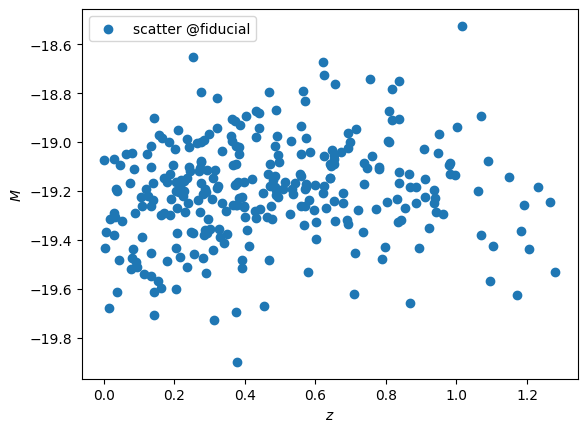

In [15]:
# plot truth just to be sure
true_alpha = 0.13
true_beta = 2.56
true_omegam = 0.3
true_omegade = 0.7

true_cosmo = set_cosmology(true_omegam, omegade=true_omegam)

zs = np.linspace(0, 1.2, num=500)
%time myM = -(muz(true_cosmo, z) - true_alpha*datadf["x1"] + true_beta*datadf["c"]) + datadf['mb']
plt.scatter(z, myM, label='scatter @fiducial')

plt.xlabel(r'$z$')
plt.ylabel(r'$M$')
plt.legend()
plt.show()

# checking the log correction factor
- check as a function of cosmology and compare to the vanilla log-likelihood

In [16]:
# test the correction term as a function of cosmology (compare to Rubin)

def rubin_log_correction_single(param, cosmo, selection_param, phi, z):
    indv_fn = lambda phi: log_indiv_selection_fn(phi, selection_param=selection_param)
    log_numerator = jax.vmap(indv_fn)(phi)
    
    mu = (muz(cosmo, z, single=True))
    myfunc = lambda m: log_latent_marginalized_indiv_selection_fn(m, param=param, selection_param=selection_param)
    log_denominator = jax.vmap(myfunc)(mu)
    
    return np.sum(log_numerator) - log_denominator #- np.sum(log_denominator)

@jax.jit
def vincent_log_correction(param, cosmo, selection_param, phi, ndat):
    indv_fn = lambda phi: log_indiv_selection_fn(phi, selection_param=selection_param)
    log_numerator = jax.vmap(indv_fn)(phi) #[log_indiv_selection_fn(phi_i, selection_param) for phi_i in phi]
    #print('lognumerator: ', np.sum(log_numerator))
    #print('other part: ', ndat * log_redshift_marginalized_indiv_selection_fn(param, selection_param, cosmo_param))
    return (np.sum(log_numerator) - ndat * log_redshift_marginalized_indiv_selection_fn(param, cosmo, selection_param))


def get_our_logfactor(omegam, omegade):
    cosmo = set_cosmology(omegam=omegam, omegade=omegade)
    param = [0.13, 2.56, 1.0, 0.1, 0.1, 0.0, 0.0, -19.3] #[α, β, Rx, Rc, np.sqrt(σ_res_sq), cstar, xstar, M0]
    return vincent_log_correction(param, cosmo, selection_param, data, ndat=data.shape[0])

def get_rubin_logfactor(omegam, omegade, z):
    cosmo = set_cosmology(omegam=omegam, omegade=omegade)
    param = [0.13, 2.56, 1.0, 0.1, 0.1, 0.0, 0.0, -19.3] #[α, β, Rx, Rc, np.sqrt(σ_res_sq), cstar, xstar, M0]
    return rubin_log_correction_single(param, cosmo, selection_param, data, z)
    

In [17]:
log_predictive_no_sel = 584 # obtained below from vanilla sampler run

In [30]:
# check the z-dependence of the correction factor
myom = 0.3
myde = 0.7

#zs = np.linspace(0.01, 3.0, num=10)

rubin_logfactors = np.abs(get_rubin_logfactor(myom, myde, z))



In [37]:
_max = np.max((rubin_logfactors))
_min = np.min((rubin_logfactors))

Text(0, 0.5, '$\\ln \\mathcal{L}_{\\rm Rubin}\\ / \\ \\max_z\\ \\ln \\mathcal{L}_{\\rm Rubin}$')

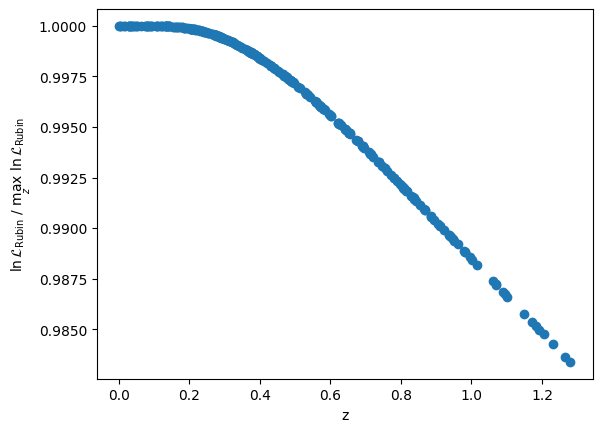

In [45]:
plt.scatter(z, ((rubin_logfactors)) / (_max))
plt.xlabel('z')
plt.ylabel(r'$\ln \mathcal{L}_{\rm Rubin}\ / \ \max_z\ \ln \mathcal{L}_{\rm Rubin}$')

In [ ]:
from tqdm import tqdm

num = 12
oms = np.linspace(0.1, 1.0, num=num)
omdes = np.linspace(0.1, 1.0, num=num)

oms,omdes = np.meshgrid(oms, omdes)
our_logfactors = []
rubin_logfactors = []

rubin_fid = get_rubin_logfactor(0.3, 0.7, z)
our_fid = get_our_logfactor(0.3, 0.7)

for i,(_om,_ode) in tqdm(enumerate(zip(oms, omdes))):
    our_logfactors.append(jax.vmap(get_our_logfactor)(_om, _ode))
    fn = lambda o,d: get_rubin_logfactor(o,d, z=z)
    rubin_logfactors.append(jax.vmap(fn)(_om, _ode))

our_logfactors = np.array(our_logfactors).reshape(num,num)
rubin_logfactors = np.array(rubin_logfactors).reshape(num,num)


In [93]:
log_predictive_no_sel = 584 # obtained below from vanilla sampler run

NameError: name 'oms' is not defined

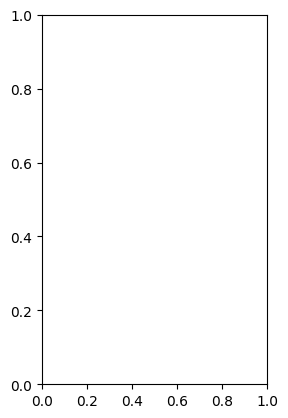

In [61]:
plt.subplot(121)
plt.contourf(oms,omdes, our_logfactors / log_predictive_no_sel, levels=12)
plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"$\Omega_\Lambda$")
plt.title(r"Ours $\ln \mathcal{L}_{\rm corr} / \ln \mathcal{L}_{\rm vanilla}$")

plt.colorbar()

plt.subplot(122)
plt.contourf(oms,omdes, rubin_logfactors / log_predictive_no_sel, levels=12)
plt.xlabel(r"$\Omega_m$")
#plt.ylabel(r"$\Omega_\Lambda$")
plt.title(r"Rubin $\mathcal{L}_{\rm corr} / \ln \mathcal{L}_{\rm vanilla}$")

plt.colorbar()

plt.tight_layout()

In [90]:
np.exp(-0.12)

Array(0.8869204, dtype=float32, weak_type=True)

## run sampler with selection effects

In [71]:
numpyro.set_platform('gpu')

In [72]:
rng_key_ = jax.random.PRNGKey(0)
#rng_key, rng_key_ = random.split(rng_key)

kernel = NUTS(bahamas, target_accept_prob=0.8)
            #  init_strategy=numpyro.infer.init_to_value(values={"OmDE": 0.7}))
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1500, jit_model_args=True)
mcmc.run(rng_key_, z=z, data=data, Cov=covs, snID=ID, ndat=ndat)
#mcmc.print_summary()

sample: 100%|██████████| 2500/2500 [02:00<00:00, 20.70it/s, 63 steps of size 1.01e-01. acc. prob=0.91] 


In [99]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      M[0]    -19.33      0.09    -19.33    -19.46    -19.19    272.67      1.00
      M[1]    -19.29      0.10    -19.29    -19.46    -19.12    341.70      1.00
      M[2]    -19.38      0.10    -19.38    -19.56    -19.22    847.78      1.00
      M[3]    -19.38      0.09    -19.38    -19.53    -19.23    797.47      1.01
      M[4]    -19.34      0.10    -19.34    -19.50    -19.16    533.21      1.00
      M[5]    -19.29      0.10    -19.29    -19.46    -19.14    360.82      1.00
      M[6]    -19.24      0.10    -19.25    -19.40    -19.08    321.86      1.01
      M[7]    -19.25      0.10    -19.25    -19.41    -19.09    447.81      1.00
      M[8]    -19.35      0.10    -19.35    -19.53    -19.21    301.19      1.01
      M[9]    -19.28      0.10    -19.28    -19.44    -19.11    352.02      1.00
     M[10]    -19.30      0.09    -19.30    -19.44    -19.14    346.75      1.00
     M[11]    -19.41      0

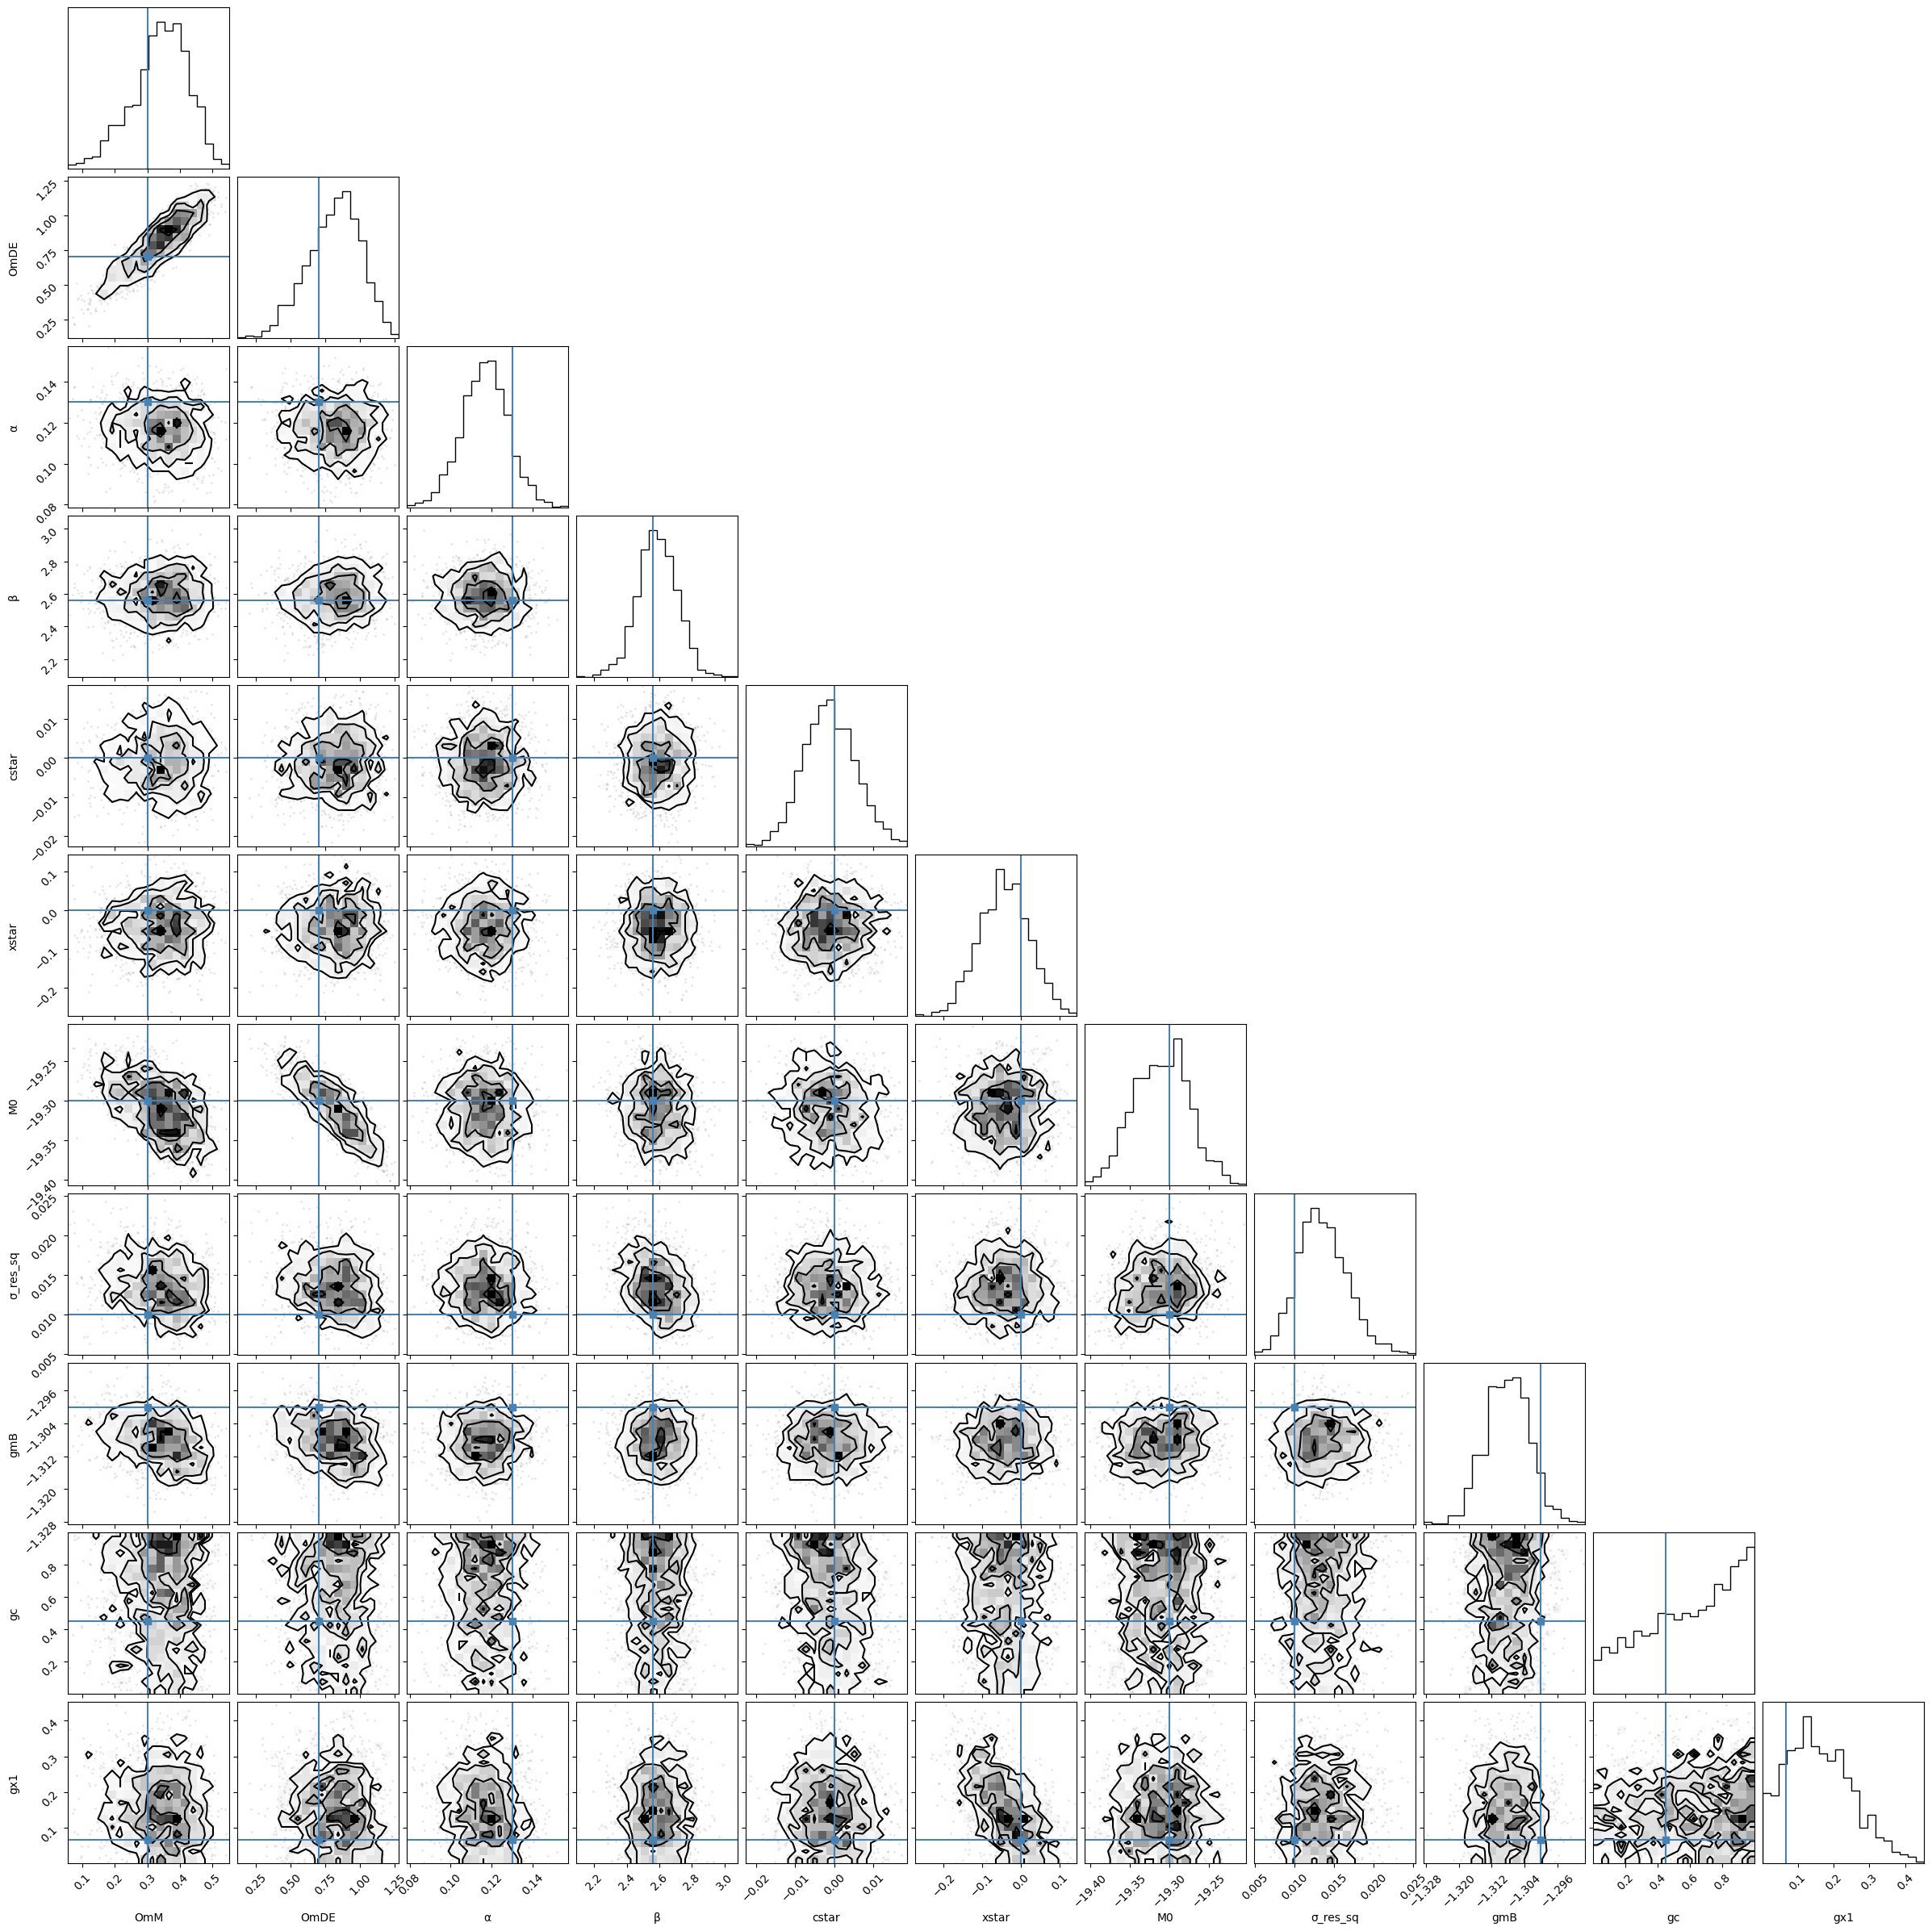

In [73]:
import corner

samples = mcmc.get_samples()
labels = ['OmM', 'OmDE', 'α', 'β', 'cstar', 'xstar', 'M0', 'σ_res_sq', 'gmB', 'gc', 'gx1'] #list(samples.keys())

#eps,gmB,gc,gx1 = (40, -1.75,  0.65,  0.06703621)
truths = [0.3, 0.7, 0.13, 2.56, 0.0, 0.0, -19.3, 0.1**2, gmB, gc, gx1]

#omM, omDE = samples['cosmo'].T

flat_samples = onp.stack([samples[lab] for lab in labels]).T #np.stack(list([omM, omDE]), axis=1)
OmM_true, OmDE_true = 0.3, -1.0

fig = corner.corner(
    flat_samples, labels=labels, truths=truths
);

#plt.savefig("post_with_selection_effects", dpi=400)

In [51]:
selection_param

(0.45, 0.06703621, -1.3, 29.96879778)

# run model WITHOUT selection effects

In [25]:
from functools import partial

rng_key_ = jax.random.PRNGKey(0) # same model key for consistency

# turn off the selection effects
bahamas_no_sel = lambda z,data,Cov,snID,ndat: bahamas(z,data,Cov,snID,ndat, do_selection=False)
# bahamas_no_sel = partial(bahamas, do_selection=False)

kernel2 = NUTS(bahamas_no_sel, target_accept_prob=0.8)#,
    #          init_strategy=numpyro.infer.init_to_value(values={"OmDE": 0.7}))

mcmc2 = MCMC(kernel2, num_warmup=500, num_samples=2000, jit_model_args=True)

mcmc2.run(rng_key_, z=z, data=data, Cov=covs, snID=ID, ndat=ndat)
#mcmc2.print_summary()

sample: 100%|██████████| 2500/2500 [02:05<00:00, 19.88it/s, 63 steps of size 6.77e-02. acc. prob=0.95] 


## plot vanilla posterior

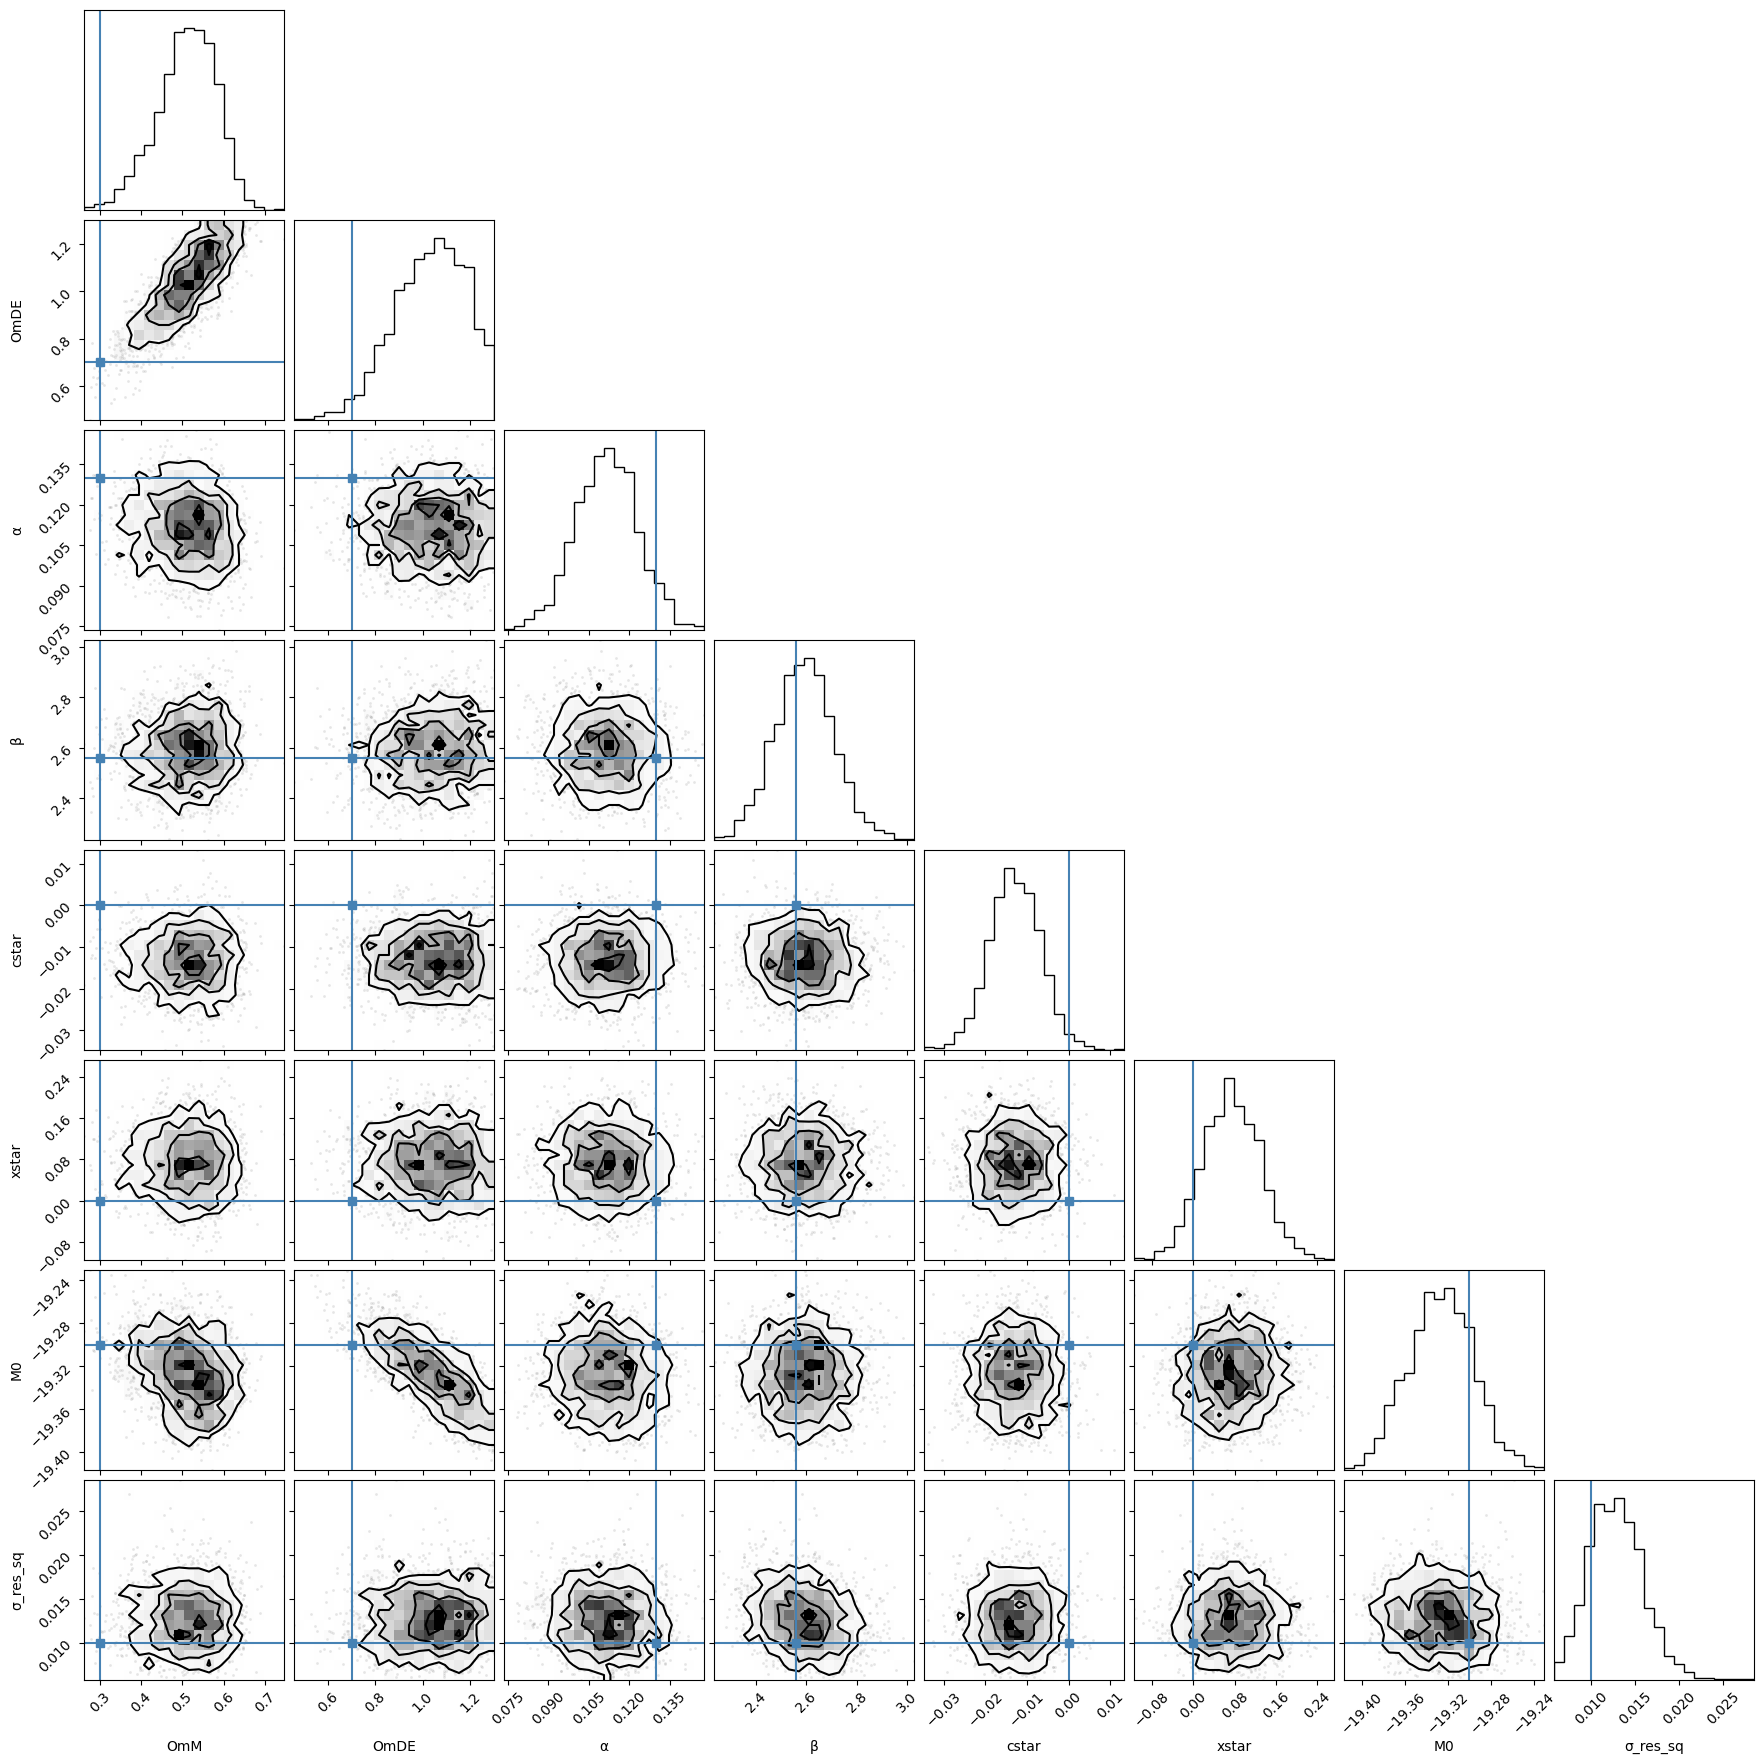

In [26]:
samples2 = mcmc2.get_samples()
labels = ['OmM', 'OmDE', 'α', 'β', 'cstar', 'xstar', 'M0', 'σ_res_sq'] #list(samples.keys())

truths = [0.3, 0.7, 0.13, 2.56, 0.0, 0.0, -19.3, 0.1**2]

flat_samples2 = onp.stack([samples2[lab] for lab in labels]).T #np.stack(list([omM, omDE]), axis=1)
OmM_true, OmDE_true = 0.3, -1.0

fig = corner.corner(
    flat_samples2, labels=labels, truths=truths
);

# obtain maximum log-likelihood density value to compare selection effects handling

In [42]:
from numpyro import handlers
from jax.scipy.special import logsumexp


def log_likelihood(rng_key, params, model, *args, **kwargs):
    model = handlers.substitute(handlers.seed(model, rng_key), params)
    model_trace = handlers.trace(model).get_trace(*args, **kwargs)
    obs_node = model_trace['obs']
    return obs_node['fn'].log_prob(obs_node['value'])

def log_predictive_density(rng_key, params, model, *args, **kwargs):
    n = list(params.values())[0].shape[0]
    log_lk_fn = vmap(lambda rng_key, params: log_likelihood(rng_key, params, model, *args, **kwargs))
    log_lk_vals = log_lk_fn(random.split(rng_key, n), params)
    return np.sum(logsumexp(log_lk_vals, 0) - np.log(n))

print(log_predictive_density(jax.random.PRNGKey(22), mcmc2.get_samples(),
      bahamas_no_sel, z=z, data=data, Cov=covs, snID=ID, ndat=ndat))  

584.31665


# do the Rubin correction

In [102]:
from functools import partial

rng_key_ = jax.random.PRNGKey(34) # same model key for consistency

# turn off the selection effects
bahamas_rubin = lambda z,data,Cov,snID,ndat: bahamas(z,data,Cov,snID,ndat, do_selection=True, do_rubin=True)

kernel3 = NUTS(bahamas_rubin, target_accept_prob=0.8)#,
mcmc3 = MCMC(kernel3, num_warmup=500, num_samples=2000, jit_model_args=True)

mcmc3.run(rng_key_, z=z, data=data, Cov=covs, snID=ID, ndat=ndat)

sample: 100%|██████████| 2500/2500 [10:52<00:00,  3.83it/s, 255 steps of size 2.22e-02. acc. prob=0.95]


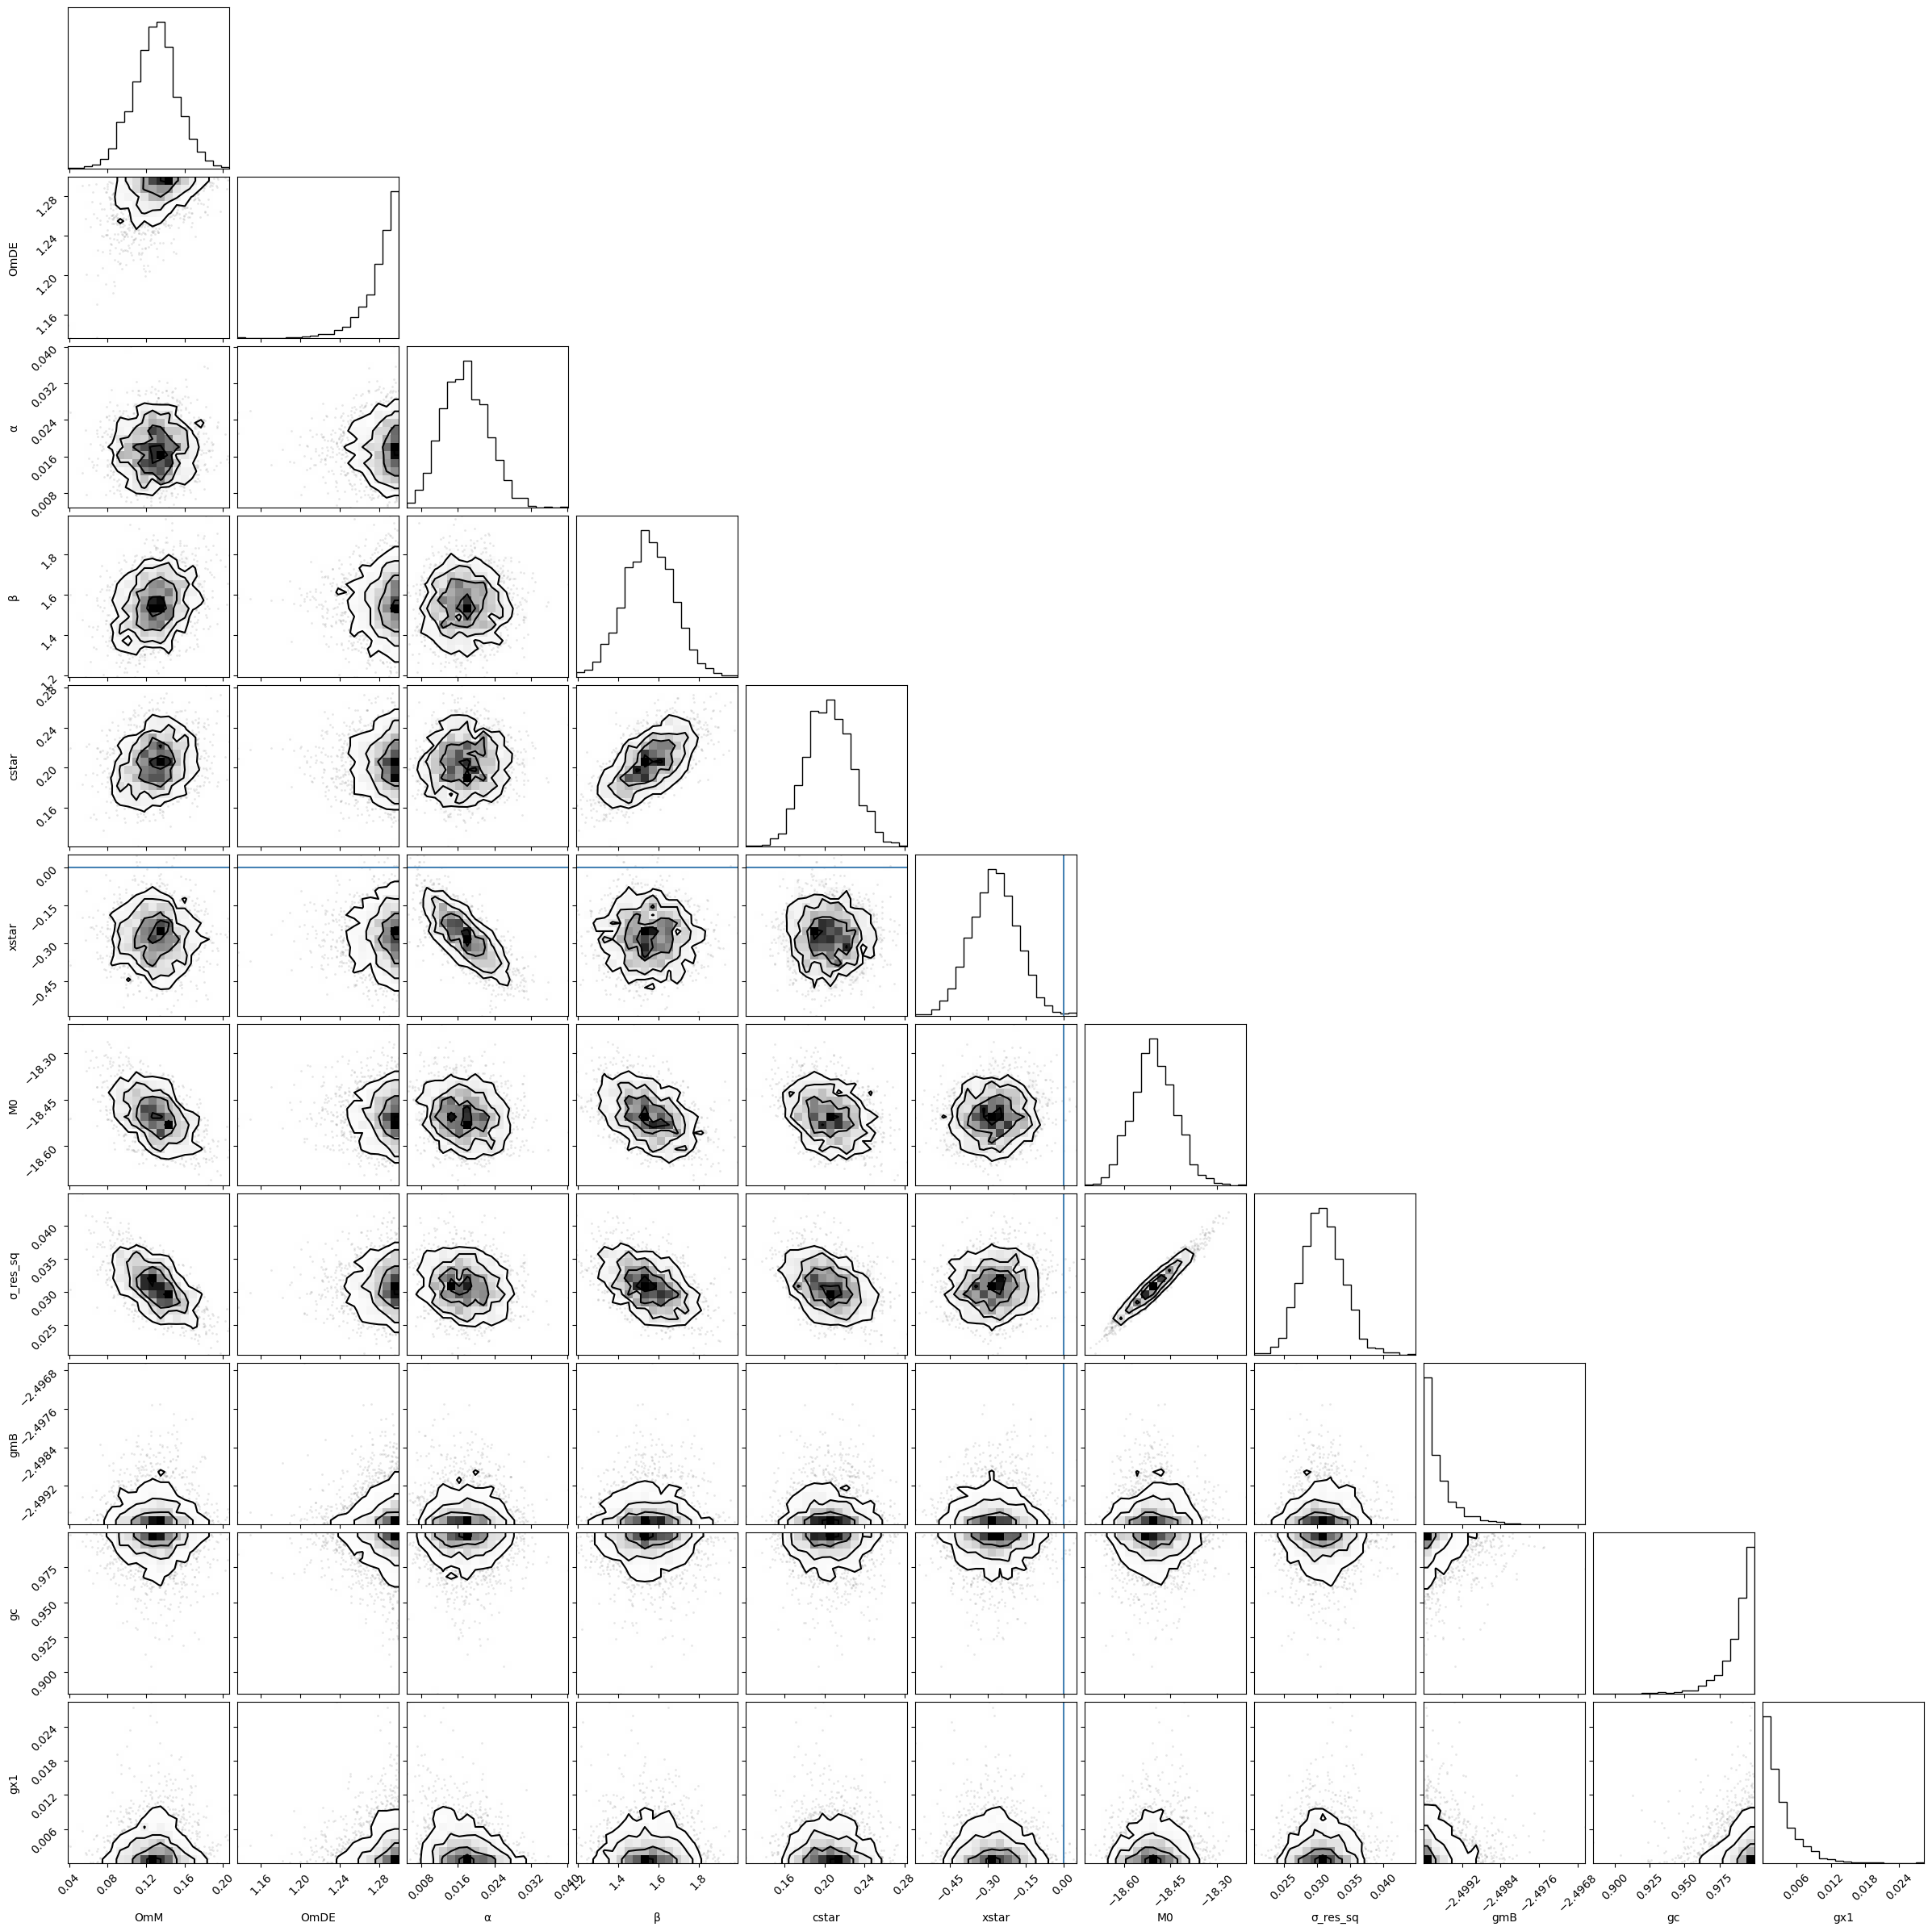

In [103]:
import corner

samples = mcmc3.get_samples()
labels = ['OmM', 'OmDE', 'α', 'β', 'cstar', 'xstar', 'M0', 'σ_res_sq', 'gmB', 'gc', 'gx1'] #list(samples.keys())

#eps,gmB,gc,gx1 = (40, -1.75,  0.65,  0.06703621)
truths = [0.3, 0.7, 0.13, 2.56, 0.0, 0.0, -19.3, 0.1**2, gmB, gc, gx1]

flat_samples3 = onp.stack([samples[lab] for lab in labels]).T #np.stack(list([omM, omDE]), axis=1)
OmM_true, OmDE_true = 0.3, -1.0

fig = corner.corner(
    flat_samples3, labels=labels, truths=truths
);

# plot them all together with chainconsumer

In [36]:
def get_flat_samples(mcmc, labels, truths):
    samples = mcmc.get_samples()
    return onp.stack([samples[lab] for lab in labels]).T    

labels = ['OmM', 'OmDE', 'α', 'β', 'cstar', 'xstar', 'M0', 'σ_res_sq'] #list(samples.keys())
truths = [0.3, 0.7, 0.13, 2.56, 0.0, 0.0, -19.3, 0.1**2]

flat_samples = get_flat_samples(mcmc, labels, truths)
flat_samples3 = get_flat_samples(mcmc3, labels, truths)




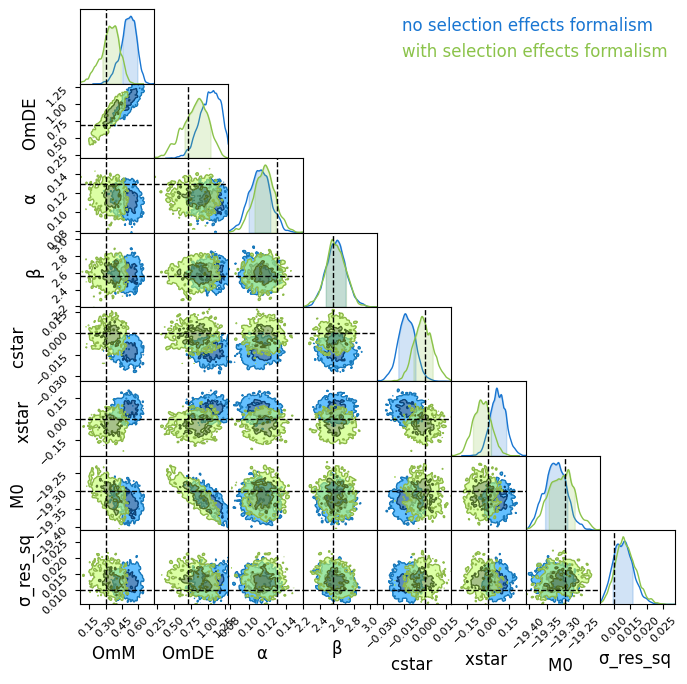

In [37]:
from chainconsumer import ChainConsumer

labels = ['OmM', 'OmDE', 'α', 'β', 'cstar', 'xstar', 'M0', 'σ_res_sq'] #list(samples.keys())

truths = [0.3, 0.7, 0.13, 2.56, 0.0, 0.0, -19.3, 0.1**2]


cs = ChainConsumer()
cs.add_chain(flat_samples2, parameters=labels, name='no selection effects formalism') #, color=corner_colors[0])
cs.add_chain(flat_samples, parameters=labels, name='with selection effects formalism') #, color=corner_colors[0])


#cs.add_covariance(θ_target, -Finv_analytic, parameters=params, name="Analytic Fisher", color=corner_colors[2])
cs.configure(linestyles=["-", "-", "-"], linewidths=[1.0, 1.0, 1.0], usetex=False,
        shade=[True, True, False], shade_alpha=[0.7, 0.6, 0.], tick_font_size=8, sigma2d=True)
cs.plotter.plot((7,7), truth=truths)

#plt.savefig('comparison_plot_selection_effects', dpi=400)
plt.show()

# check model latents
Now that we've run our inference, we can take a look at how our model did. First compare latents to plug-in estimates for various quantities

In [31]:
datafname = datapath + 'lc_params_sel.txt'

# load data

names = ['z', 'c', 'x1', 'mb']
datadf = pd.read_csv(datafname, header=0, sep='\s+', usecols=names)
z = datadf['z'].values

# unpack block diags
sigmaC = onp.array(onp.loadtxt(datapath + 'cov_sel.txt'))
M = int(3)
covs = np.array([sigmaC[i*M:(i+1)*M,i*M:(i+1)*M] for i in range(sigmaC.shape[0]//M)])

# for each set of posterior samples, look at population level constraints

mus_to_plot  = []

for s in [samples, samples2]:

  # compute mus for each SN
  _OmM = np.mean(s['OmM'])
  _w = np.mean(s['OmDE'])
  _beta = np.mean(s['β'])
  _alpha = np.mean(s['α'])

  _mus = muz(_OmM, _w, z) - _alpha*datadf['x1'].values + _beta*datadf['c'].values

  mus_to_plot.append(_mus)


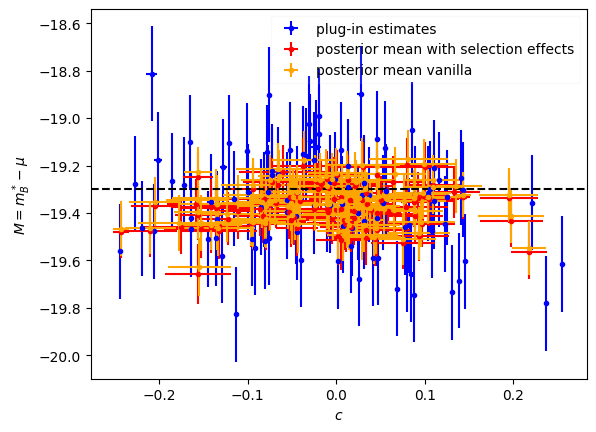

In [32]:
cobserr = [covs[i][0, 0] for i in range(len(covs))]

all_samples = [samples, samples2]
labels = ["with selection effects", "vanilla"]
colors = ['r', 'orange']

plt.errorbar(datadf['c'],
             datadf['mb'] - _mus,
             yerr = np.std(datadf['mb'].values - _mus, axis=0),fmt='.',
             xerr = cobserr, c='b', label='plug-in estimates')

for i,s in enumerate(all_samples):

  plt.errorbar(np.mean(s['c'], axis=0),
              np.mean(s['M'], axis=0),
              yerr = np.std(s['M'], axis=0),fmt='.',
              xerr = np.std(s['c'], axis=0), c=colors[i], label='posterior mean ' + labels[i])

plt.axhline(-19.3, ls='--', c='k')

plt.ylabel(r"$M = m^*_B - \mu$")
plt.xlabel(r'$c$')
plt.legend(framealpha=0.1)

In [ ]:
samples['x1'].shape

samples["M"].shape

(500, 25)

In [ ]:
len(x1obserr), len(cobserr)

(99, 99)

In [ ]:
covs.shape

(99, 3, 3)

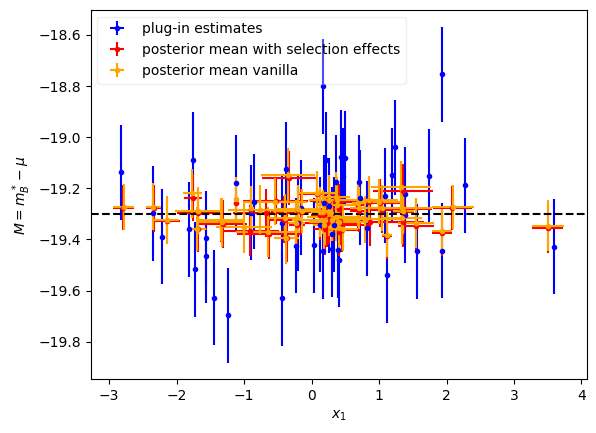

In [ ]:
x1obserr = [covs[i][1, 1] for i in range(len(covs))]



all_samples = [samples, samples2]
labels = ["with selection effects", "vanilla"]
colors = ['r', 'orange']

plt.errorbar(datadf['x1'],
             datadf['mb'] - _mus,
             yerr = np.std(datadf['mb'].values - _mus, axis=0),fmt='.',
             xerr = cobserr, c='b', label='plug-in estimates')

for i,s in enumerate(all_samples):

  plt.errorbar(np.mean(s['x1'], axis=0),
              np.mean(s['M'], axis=0),
              yerr = np.std(s['M'], axis=0),fmt='.',
              xerr = np.std(s['x1'], axis=0), c=colors[i], label='posterior mean ' + labels[i])


plt.axhline(-19.3, ls='--', c='k')

plt.ylabel(r"$M = m^*_B - \mu$")
plt.xlabel(r'$x_1$')
plt.legend(framealpha=0.3)

We observe that using the posterior mean of latents for residual $M_i$ calculation reduces spread with respect to $c$ and $x_1$ light curve parameters.

# the money plot
Isolate the corner for $\Omega_m$-$w$ inference

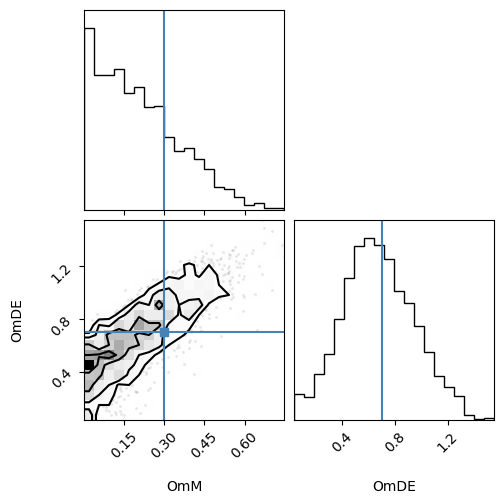

In [34]:
samples = mcmc.get_samples()
labels = ['OmM', 'OmDE'] #list(samples.keys())

truths = [0.3, 0.7]

#omM, omDE = samples['cosmo'].T

flat_samples = onp.stack([samples[lab] for lab in labels]).T #np.stack(list([omM, omDE]), axis=1)
OmM_true, OmDE_true = 0.3, -1.0

fig = corner.corner(
    flat_samples, labels=labels, truths=truths
);